## DeepLoop Prediction

This notebook will walk through how to utilize the pretrained LoopDenoise and LoopEnhance models. Users can feed entire chromosomes or genomes into our provided scripts to run the models on a whole dataset using the same matrix splitting process that we use in the paper. Users can also load the models into their own Python scripts and use them in their own workflows.

### Using trained models

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'  # force tensorflow to run on CPU
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-deep')

from utils.utils import draw_heatmap

Usually we are interested in denoising an entire chromosome or an entire genome (within 2Mb interactions). However, since DeepLoop models are trained on small matrix tiles, we need to split each chromosome matrix into these tiles, run the model prediction, then recombine them. We provide scripts to easily run prediction and recombination of whole chromosomes or an entire genome.

### LoopDenoise Prediction

In [49]:
! python3 ../prediction/predict_chromosome.py -h

2021-08-25 09:52:56.284632: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-25 09:52:56.284714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: predict_chromosome.py [-h] [--full_matrix_dir FULL_MATRIX_DIR]
                             [--input_name INPUT_NAME] [--h5_file H5_FILE]
                             [--json_file JSON_FILE] [--out_dir OUT_DIR]
                             [--anchor_dir ANCHOR_DIR]
                             [--chromosome CHROMOSOME]
                             [--small_matrix_size SMALL_MATRIX_SIZE]
                             [--step_size STEP_SIZE] [--max_dist MAX_DIST]
                             [--dummy DUMMY]
                         

In [50]:
! python3 ../prediction/predict_chromosome.py --full_matrix_dir ../training_data/H9_full/ \
                                              --input_name anchor_2_anchor.loop.chr11.p_val \
                                              --h5_file models/denoise_model/cp_gz_denoise.h5 \
                                              --out_dir output/H9_denoised/ \
                                              --anchor_dir ../training_data/anchor_bed/ \
                                              --chromosome chr11 \
                                              --small_matrix_size 128 \
                                              --step_size 128 \
                                              --dummy 5 \
                                              --val_cols obs exp pval

2021-08-25 09:54:40.868830: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-25 09:54:40.868870: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-25 09:54:43.439055: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-25 09:54:43.439137: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-25 09:54:43.439199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

This script will output the denoised or enhanced interactions as a tab-separated list of `anchor1` `anchor2` `value` triplets. If you would like, you can use our `convert_to_cooler.py` script to convert any interactions of this format into a cooler file.

In [29]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_full/ \
                                        --out_file coolers/H9_full_chr11.cool \
                                        --col_names a1 a2 obs exp pval \
                                        --cooler_col ratio \
                                        --single_chrom chr11;

coolers/H9_full_chr11.cool
100%|███████████████████████████████████████████| 24/24 [00:14<00:00,  1.62it/s]
Saving cooler...


In [30]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir output/H9_denoised/ \
                                        --out_file coolers/H9_denoise_chr11.cool \
                                        --col_names a1 a2 denoise \
                                        --cooler_col denoise \
                                        --single_chrom chr11;

coolers/H9_denoise_chr11.cool
100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]
Saving cooler...


Now we can easily visualize heatmaps by loading the cooler file and accessing the matrix. We provide the `heatmap_from_cooler.py` script to access and save a single heatmap from a cooler file.

In [48]:
! python3 ../utils/heatmap_from_cooler.py --cool_file coolers/H9_denoise_chr11.cool \
                                          --locus chr11:130,000,000-131,000,000 \
                                          --out_file heatmaps/heatmap_test.png;

Another option is to load the cooler file yourself and access the matrix to visualize in your favorite plotting toolkit.

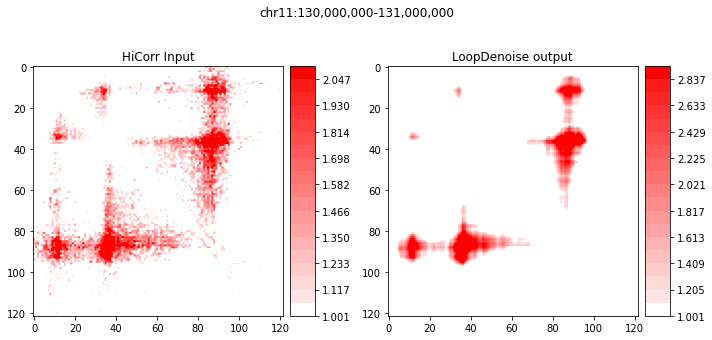

In [31]:
import cooler

locus = 'chr11:130,000,000-131,000,000'

c_denoise = cooler.Cooler('coolers/H9_denoise_chr11.cool')
c_ratio = cooler.Cooler('coolers/H9_full_chr11.cool')
mat_denoise = c_denoise.matrix().fetch(locus)
mat_ratio = c_ratio.matrix().fetch(locus)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat_ratio, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(mat_denoise, 0, ax=axs[1], return_plt_im=True)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopDenoise output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

We also provide an option to map the non-uniform anchors/bins from DpNII or HindIII data to uniform bin sizes for visualization in HiGlass (https://higlass.io/). Refer to the `walkthrough_cooler.ipynb` notebook if you would like to interactively visualize the output of DeepLoop or any other Hi-C data in similar format.

### LoopEnhance Prediction

The same `predict_chromosome.py` script can be used to run *LoopEnhance* models, we just need to point it at the weights file of a different model. The overall pipeline is identical to that of *LoopDenoise*.

In [51]:
! python3 ../prediction/predict_chromosome.py --full_matrix_dir ../training_data/H9_15M/rep1/ \
                                              --input_name anchor_2_anchor.loop.chr11 \
                                              --h5_file models/enhance_model/enhance_CP_GZ_015.h5 \
                                              --out_dir output/H9_15M_enhance/ \
                                              --anchor_dir ../training_data/anchor_bed/ \
                                              --chromosome chr11 \
                                              --small_matrix_size 128 \
                                              --step_size 128 \
                                              --dummy 5;

! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_15M/rep1/ \
                                        --out_file coolers/H9_15M_chr11.cool \
                                        --col_names a1 a2 obs exp \
                                        --cooler_col ratio \
                                        --single_chrom chr11;

! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir output/H9_15M_enhance/ \
                                        --out_file coolers/H9_15M_enhance_chr11.cool \
                                        --col_names a1 a2 enhance \
                                        --cooler_col enhance \
                                        --single_chrom chr11;

2021-08-25 09:56:46.385785: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-25 09:56:46.385827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-25 09:56:50.235046: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-25 09:56:50.235092: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-25 09:56:50.235133: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

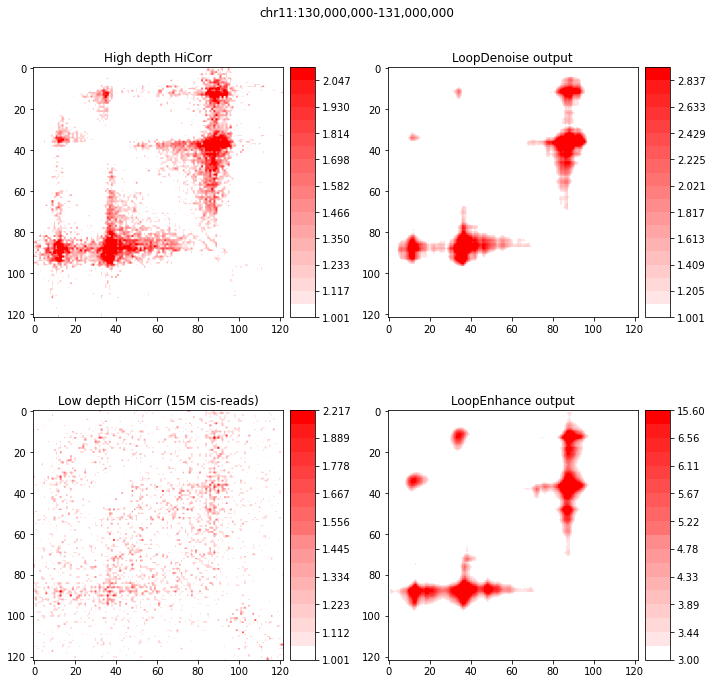

In [3]:
c_denoise = cooler.Cooler('coolers/H9_denoise_chr11.cool')
c_ratio_full = cooler.Cooler('coolers/H9_full_chr11.cool')
c_ratio_down = cooler.Cooler('coolers/H9_15M_chr11.cool')
c_enhance = cooler.Cooler('coolers/H9_15M_enhance_chr11.cool')

mat_denoise = c_denoise.matrix().fetch(locus)
mat_ratio_full = c_ratio_full.matrix().fetch(locus)
mat_enhance = c_enhance.matrix().fetch(locus)
mat_ratio_down = c_ratio_down.matrix().fetch(locus)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

im = draw_heatmap(mat_ratio, 0, ax=axs[0][0], return_plt_im=True)
divider = make_axes_locatable(axs[0][0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0][0].set_title('High depth HiCorr')

im = draw_heatmap(mat_denoise, 0, ax=axs[0][1], return_plt_im=True)
divider = make_axes_locatable(axs[0][1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0][1].set_title('LoopDenoise output')

im = draw_heatmap(mat_ratio_down, 0, ax=axs[1][0], return_plt_im=True)
divider = make_axes_locatable(axs[1][0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1][0].set_title('Low depth HiCorr (15M cis-reads)')

im = draw_heatmap(mat_enhance, 7, min_val=3, ax=axs[1][1], return_plt_im=True)
divider = make_axes_locatable(axs[1][1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1][1].set_title('LoopEnhance output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

### Integrating models directly into your workflow

Once a model is trained and saved, it can be used to denoise new Hi-C matrices in your own scripts. To load a model, we use the `.json` file to load the architecture and the `.h5` file to load the trained weights. Note that TensorFlow can also save the full model and training state as a `.h5` file using the `model.save()` function

In [13]:
from tensorflow.keras.models import model_from_json

json_file = 'models/denoise_model/cp_gz_denoise.json'
h5_file = 'models/denoise_model/cp_gz_denoise.h5'

with open(json_file, 'r') as f:
    model = model_from_json(f.read())  # load model
model.load_weights(h5_file)  # load model weights
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1360      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     10824     
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 8)     0   

Here we will demonstrate how to denoise and visualize a heatmap starting from a cooler file. For completeness, the cell below demonstrates how we generated the cooler file we will be using.

In [310]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_full/ \
                                        --out_file coolers/H9_full.cool \
                                        --col_names a1 a2 obs exp pval \
                                        --cooler_col ratio;

coolers/H9_full.cool
100%|███████████████████████████████████████████| 24/24 [08:20<00:00, 20.83s/it]
              a1      a2     ratio   chr  chr_a1  chr_a2
0              0       1  0.981176  chr1       0       1
1              0       2  1.000000  chr1       0       2
2              0       3  0.999842  chr1       0       3
3              0       4  1.000000  chr1       0       4
4              0       5  0.997847  chr1       0       5
...          ...     ...       ...   ...     ...     ...
77069316  334610  334612  1.000000  chrY    2987    2989
77069317  334610  334613  1.000000  chrY    2987    2990
77069318  334611  334612  1.000000  chrY    2988    2989
77069319  334611  334613  1.000000  chrY    2988    2990
77069320  334612  334613  1.000000  chrY    2989    2990

[77069321 rows x 6 columns]
a1          int64
a2          int64
ratio     float64
chr        object
chr_a1      int64
chr_a2      int64
dtype: object
Saving cooler...
334612 334613 334614


In [336]:
c = cooler.Cooler('coolers/H9_full.cool')
c.info

{'bin-size': None,
 'bin-type': 'variable',
 'creation-date': '2021-08-19T10:09:27.240557',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'hg19',
 'metadata': {},
 'nbins': 334614,
 'nchroms': 24,
 'nnz': 77069321,
 'storage-mode': 'symmetric-upper',
 'sum': 79341555.57598312}

In [312]:
locus = 'chr11:130,000,000-131,000,000'

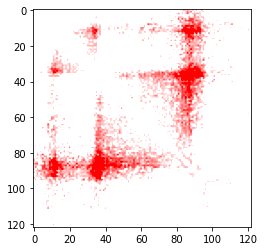

In [313]:
mat = c.matrix().fetch(locus)
draw_heatmap(mat, 0)

Typically, we would denoise many heatmaps at once in a batch. Additionally, the model expects each heatmap to have a single channel. So we need to ensure that the input is a 4-dimensional array. In the case of a single heatmap this corresponds to a shape of `(1, _, _, 1)`

In [17]:
def add_dims(x):
    if len(x.shape) == 2:
        return np.expand_dims(np.expand_dims(x, 0), -1)
    elif len(x.shape) == 3:
        return np.expand_dims(x, -1)
    else:
        return x

Here we use the model to predict the denoised values, then we force the output matrix to be symmetric by averaging across the diagonal.

In [338]:
enhanced_mat = model.predict(add_dims(mat))[0, ..., 0]
enhanced_mat = (enhanced_mat + enhanced_mat.T) / 2

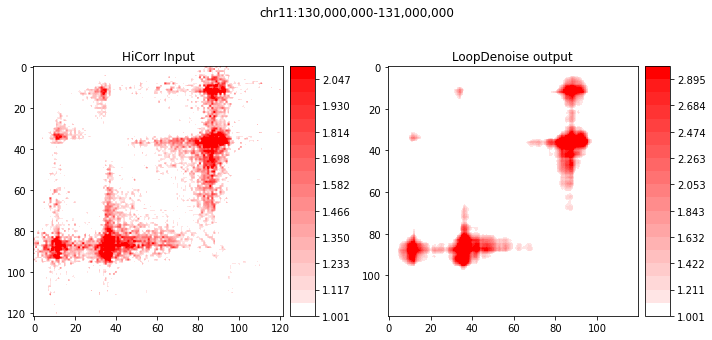

In [339]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(enhanced_mat, 0, ax=axs[1], return_plt_im=True)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopDenoise output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

### LoopEnhance Demo

The LoopEnhance models can used in nearly the exact same way has the LoopDenoise models. However, due to the pooling layers and skip connections, we require that your input be at least divisible by $2^d$ where $d$ is the depth of the model (we use $d=4$ in our models).

In [14]:
json_file = 'models/enhance_model/enhance_CP_GZ_015.json'
h5_file = 'models/enhance_model/enhance_CP_GZ_015.h5'

with open(json_file, 'r') as f:
    model = model_from_json(f.read())  # load model
model.load_weights(h5_file)  # load model weights
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 4 328         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 4 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 4 1300        activation_1[0][0]               
____________________________________________________________________________________________

One caveat to the LoopEnhance architecture is that our input matrix must be divisible by $2^6=64$ due to model depth. Otherwise the output matrix will not have the correct size.

In [35]:
c = cooler.Cooler('coolers/H9_15M_chr11.cool')
locus = 'chr11:130,000,000-131,050,000'
mat = c.matrix().fetch(locus)
mat.shape

(128, 128)

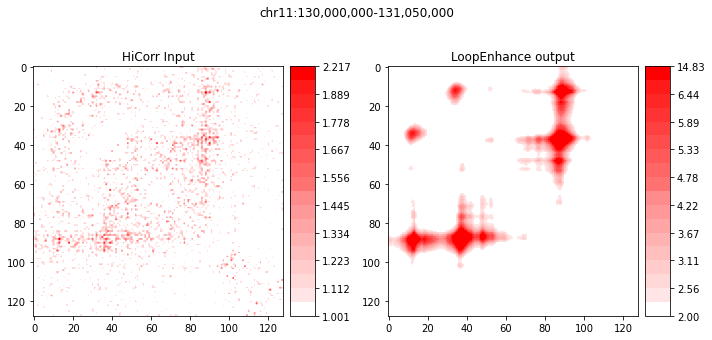

In [38]:
enhanced_mat = model.predict(add_dims(mat))[0, ..., 0]
enhanced_mat = (enhanced_mat + enhanced_mat.T) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(enhanced_mat, 7, min_val=2, ax=axs[1], return_plt_im=True)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopEnhance output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()